# k-Nearest Neighbor (kNN) exercise

* Complete y entregue esta hoja de trabajo completa (incluidos sus resultados y cualquier código de apoyo fuera de la hoja de trabajo) con el envío de su tarea.

El clasificador kNN consta de dos etapas:

- Durante el entrenamiento, el clasificador toma los datos de entrenamiento y simplemente los recuerda
- Durante la prueba, kNN clasifica cada imagen de prueba comparándola con todas las imágenes de entrenamiento y transfiriendo las etiquetas de los k primeros ejemplos de entrenamiento más similares.
- El valor de k se valida de forma cruzada

En este ejercicio, implementará estos pasos y comprenderá el proceso básico de clasificación de imágenes, la validación cruzada y obtendrá competencia en la escritura de código vectorizado eficiente.

In [5]:
# Run some setup code for this notebook.

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

import random
import numpy as np
from linear_classifiers.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'linear_classifiers/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
    del X_train, y_train
    del X_test, y_test
    print('Clear previously loaded data.')
except:
    pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


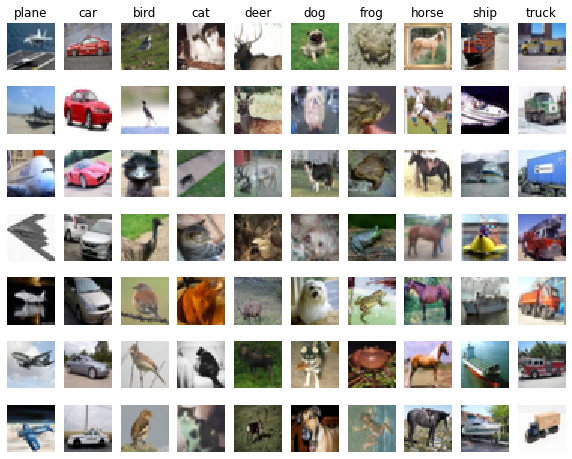

In [7]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [8]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [1]:
from linear_classifiers.classifiers import KNearestNeighbor

# Create a kNN classifier instance. 
# Remember that training a kNN classifier is a noop (no-operation): 
# the Classifier simply remembers the data and does no further processing 
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

NameError: name 'X_train' is not defined

Ahora nos gustaría clasificar los datos de prueba con el clasificador kNN. Recuerde que podemos dividir este proceso en dos pasos: 

1. Primero debemos calcular las distancias entre todos los ejemplos de prueba y todos los ejemplos en Training.
2. Dadas estas distancias, para cada ejemplo de prueba encontramos los k ejemplos más cercanos y les pedimos que voten para el Label

Comencemos con el cálculo de la matriz de distancia entre todos los ejemplos de entrenamiento y prueba. Por ejemplo, si hay ejemplos de entrenamiento **Ntr** y ejemplos de prueba **Nte**, esta etapa debería resultar en una matriz **Nte x Ntr** donde cada elemento (i, j) es la distancia entre el i-ésimo elemento de testeo y el j-ésimo ejemplo de training.

**Nota: Para los tres cálculos de distancia que requerimos que implemente en esta notebook, no puede usar la función np.linalg.norm () que proporciona numpy.**

Primero, abre `cs231n/classifiers/k_nearest_neighbor.py` e implementa la función `compute_distances_two_loops` que utiliza un bucle doble (muy ineficiente) sobre todos los pares de ejemplos (prueba, entrenamiento) y calcula la matriz de distancia un elemento a la vez.

In [7]:
# Open cs231n/classifiers/k_nearest_neighbor.py and implement
# compute_distances_two_loops.

# Test your implementation:
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(500, 5000)


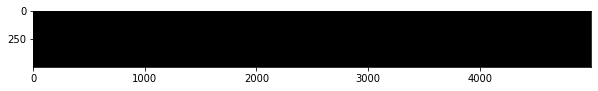

In [8]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.imshow(dists, interpolation='none')
plt.show()

**Inline Question 1** 

Observe los patrones estructurados en la matriz de distancias, donde algunas filas o columnas se ven más brillantes. (Tenga en cuenta que con el esquema de color predeterminado, el negro indica distancias bajas, mientras que el blanco indica distancias altas).

- ¿Cuál es la causa en los datos detrás de las filas claramente brillantes?
- ¿Qué causa las columnas?

$\color{blue}{\textit TuRespuesta:}$ *complétala aquí.*



In [9]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 57 / 500 correct => accuracy: 0.114000


Debería esperar ver aproximadamente un 27% de precisión. Ahora probemos una `k` más grande, digamos `k = 5`:

In [10]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 57 / 500 correct => accuracy: 0.114000


Debería esperar ver un rendimiento ligeramente mejor que con `k = 1`.

**Inline Question 2**

También podemos utilizar otras métricas de distancia como la distancia L1.
Para valores de píxeles $ p_ {ij} ^ {(k)} $ en la ubicación $ (i, j) $ de alguna imagen $ I_k $,

La media $\mu$ en todos los píxeles de todas las imágenes es $$\mu=\frac{1}{nhw}\sum_{k=1}^n\sum_{i=1}^{h}\sum_{j=1}^{w}p_{ij}^{(k)}$$
Y la media de píxeles $\mu_{ij}$ en todas las imágenes es
$$\mu_{ij}=\frac{1}{n}\sum_{k=1}^np_{ij}^{(k)}.$$

La desviación estándar general $\sigma$ y desviación estándar de píxeles $\sigma_{ij}$ se define de manera similar.

¿Cuál de los siguientes pasos de preprocesamiento no cambiará la performance de un clasificador KNN que usa la distancia L1? Seleccione todas las que correspondan.
1. Restando la media $\mu$ ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu$.)
2. Restando la media por píxel $\mu_{ij}$  ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu_{ij}$.)
3. Restando la media $\mu$ y dividiendo por la desviación estándar $\sigma$.
4. Restando la media de píxeles $\mu_{ij}$ y dividiendo por la desviación estándar de píxeles $\sigma_{ij}$.
5. Rotar los ejes de coordenadas de los datos.

$\color{blue}{\textit Tu Respuesta:}$


$\color{blue}{\textit Tu explicación:}$


In [11]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function compute_distances_one_loop and run the
# code below:
dists_one = classifier.compute_distances_one_loop(X_test)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
difference = np.linalg.norm(dists - dists_one, ord='fro')
print('One loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

One loop difference was: 0.000000
Good! The distance matrices are the same


In [12]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
dists_two = classifier.compute_distances_no_loops(X_test)

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('No loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

No loop difference was: 0.000000
Good! The distance matrices are the same


In [13]:
# Let's compare how fast the implementations are
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)

# You should see significantly faster performance with the fully vectorized implementation!

# NOTE: depending on what machine you're using, 
# you might not see a speedup when you go from two loops to one loop, 
# and might even see a slow-down.

Two loop version took 0.046517 seconds
One loop version took 0.000986 seconds
No loop version took 0.002362 seconds


### Cross-validation

Hemos implementado el clasificador k-Vecino más cercano, pero establecemos el valor k = 5 arbitrariamente. Ahora determinaremos el mejor valor de este hiperparámetro con validación cruzada.

In [ ]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
################################################################################
# TODO:                                                                        #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

pass

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}


################################################################################
# TODO:                                                                        #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

pass

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

In [ ]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [ ]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = 1

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

**Inline Question 3**

¿Cuáles de las siguientes afirmaciones sobre $k$ -Nearest Neighbor ($k$-NN) son verdaderas en una configuración de clasificación y para todos los $k$? Seleccione todas las que correspondan.

1. El límite de decisión del clasificador k-NN es lineal.
2. El error de entrenamiento de un 1-NN siempre será menor o igual que el de 5-NN.
3. El error de prueba de un 1-NN siempre será menor que el de un 5-NN.
4. El tiempo necesario para clasificar un ejemplo de prueba con el clasificador k-NN aumenta con el tamaño del conjunto de entrenamiento.
5. Ninguna de las anteriores.

$\color{blue}{\textit Tu Respuesta:}$


$\color{blue}{\textit Tu Explicación:}$

